# IRASA

This notebook measures aperiodic activity using the 'irregular resampling auto-spectral analysis' (IRASA) algorithm.

IRASA does not explicitly consider signals with a knee, nor does it consider signals where there are central frequencies with some variance around them as in the setting of FOOOF. 

The purpose of this notebook is to test the robustness of IRASA to these deviations and to quantify the error in estimating $\chi$ as we test IRASA on various signals whose power spectrum deviates from a strict $1/f$ structure.

In [1]:
# Setup notebook state
from nbutils import setup_notebook; setup_notebook()

In [2]:
import numpy as np

In [3]:
from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_combined
from neurodsp.spectral import compute_spectrum
from neurodsp.aperiodic import compute_irasa, fit_irasa
from neurodsp.utils import set_random_seed
from fooof.plts import plot_spectra

In [4]:
# Import custom project code
from apm.io import APMDB
from apm.run import run_sims, run_sims_load
from apm.methods import irasa, fit_irasa_knee
from apm.methods.settings import IRASA_PARAMS, IRASA_PARAMS_KNEE, FIT_F_RANGE, FIT_F_RANGE_LONG
from apm.plts.sims import plot_sims, plot_ap_sims, plot_pe_sims
from apm.plts.utils import figsaver
from apm.plts.settings import COLORS
from apm.plts.style import custom_psd_style_no_ticks
from apm.sim.examples import get_examples
from apm.sim.settings import N_SIMS
from apm.sim.settings import FS2 as FS
from apm.sim.defs import SIM_ITERS

## Settings

In [5]:
# Update sampling frequency for simulation definition
SIM_ITERS.update_base(fs=FS)

In [6]:
# Set data specific settings
IRASA_PARAMS['fs'] = FS
IRASA_PARAMS_KNEE['fs'] = FS

In [7]:
# Plot settings
PSD_PLT_KWARGS = {
    'log_freqs' : True,
    'log_powers' : True,
    'colors' : ['black', 'blue'],
    'alpha' : [1, 0.65],
    'labels' : ['Original Spectrum', 'Aperiodic Component'],
    'legend_loc' : 'lower left',
    'figsize' : (8.5, 6.5),
}

In [8]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '33_irasa'

# Create helper function to manage figsaver settings
fsaver = figsaver(SAVE_FIG, FIGPATH)

In [9]:
# Set the random seed
set_random_seed(111)

In [10]:
# Define collection of example signals
examples = get_examples(fs=FS)

## IRASA

IRASA stands for irregularly resampled auto-spectral analysis. It seeks to dissociate aperiodic and periodic components of the signal, under the assumption that there is a 1/f aperiodic component, with overlying periodic (rhythmic) activity. IRASA computes the aperiodic component by appealing to the self-similar nature of signals whose power spectrum obeys a power law. By resampling the time series at non-integer rates, the peaks in the power spectrum (corresponding to periodic components) will be shifted in frequency by a quantity proportional to the resampling rate. However, self-similarity of the aperiodic component ensures that the power law decay remains the same across resamplings. The periodic activity can then be averaged out across the power spectra of the resampled time series.

Note that IRASA requires the time series data (as this is what is resampled). 

In [11]:
# Check the IRASA settings
print(IRASA_PARAMS)

{'fs': 500, 'f_range': (1, 50)}


In [12]:
# Check the IRASA settings - knee
IRASA_PARAMS_KNEE

{'fs': 500, 'f_range': (1, 50), 'fit_func': 'fit_irasa_knee'}

### IRASA on Example Signals

#### Powerlaw Signal

In [13]:
# Calculate IRASA and fit exponent
freqs, psd_ap, psd_pe = compute_irasa(examples['powerlaw'], **IRASA_PARAMS)
fit_off, fit_exp = fit_irasa(freqs, psd_ap)

In [14]:
# Compute the full power spectrum
freqs_full, psd_full = compute_spectrum(examples['powerlaw'], FS, f_range=FIT_F_RANGE)

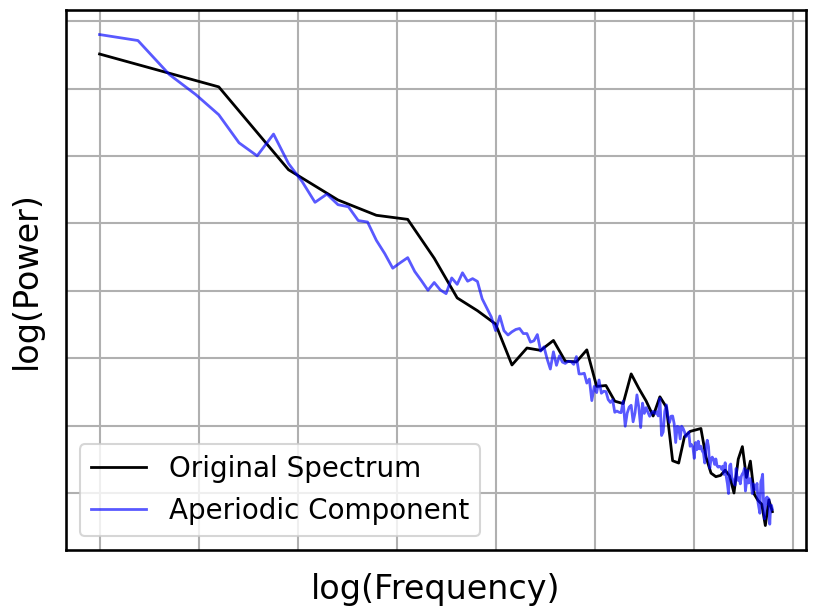

In [15]:
# Compare the full spectrum the IRASA separate aperiodic component
plot_spectra([freqs_full, freqs], [psd_full, psd_ap],
             custom_styler=custom_psd_style_no_ticks,
             **PSD_PLT_KWARGS, **fsaver('ir_example_ap'))

In [16]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(SIM_ITERS.params['ap']['exponent']))

Measured Exponent:	 -1.0019
Expected Exponent:	 -1.0000


#### Combined Signal

In [17]:
# Calculate IRASA and fit exponent
freqs, psd_ap, psd_pe = compute_irasa(examples['combined'], **IRASA_PARAMS)
fit_off, fit_exp  = fit_irasa(freqs, psd_ap)

In [18]:
# Compute the full power spectrum
freqs_full, psd_full = compute_spectrum(examples['combined'], FS, f_range=FIT_F_RANGE)

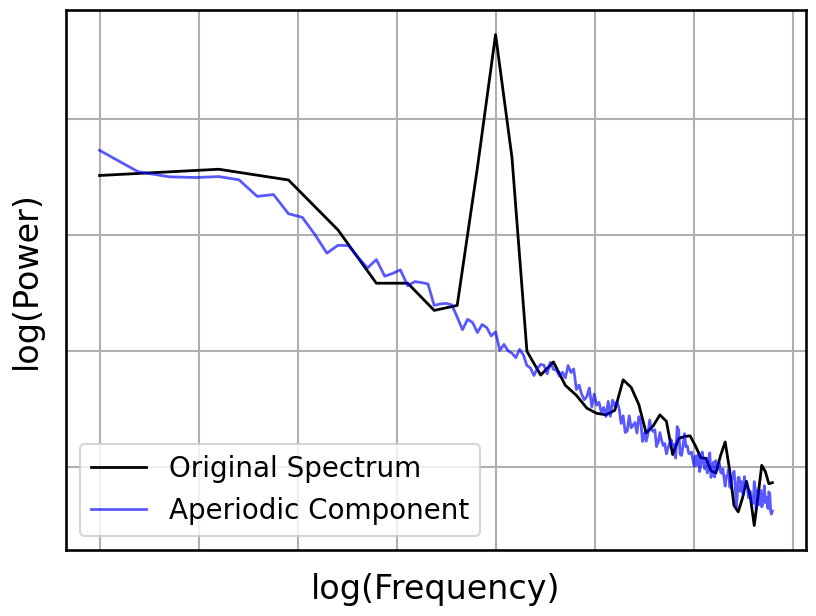

In [19]:
# Compare the full spectrum the IRASA separate aperiodic component
plot_spectra([freqs_full, freqs], [psd_full, psd_ap],
             custom_styler=custom_psd_style_no_ticks,
             **PSD_PLT_KWARGS, **fsaver('ir_example_pe'))

In [20]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(SIM_ITERS.params['ap']['exponent']))

Measured Exponent:	 -0.9992
Expected Exponent:	 -1.0000


#### Knee Signal

In [21]:
# Calculate IRASA and fit exponent
freqs, psd_ap, psd_pe = compute_irasa(examples['synaptic'], **IRASA_PARAMS)
fit_off, fit_exp  = fit_irasa(freqs, psd_ap)
fit_kn_off, fit_kn_knee, fit_kn_exp = fit_irasa_knee(freqs, psd_ap)

In [22]:
# Compute the full power spectrum
freqs_full, psd_full = compute_spectrum(examples['synaptic'], FS, f_range=FIT_F_RANGE_LONG)

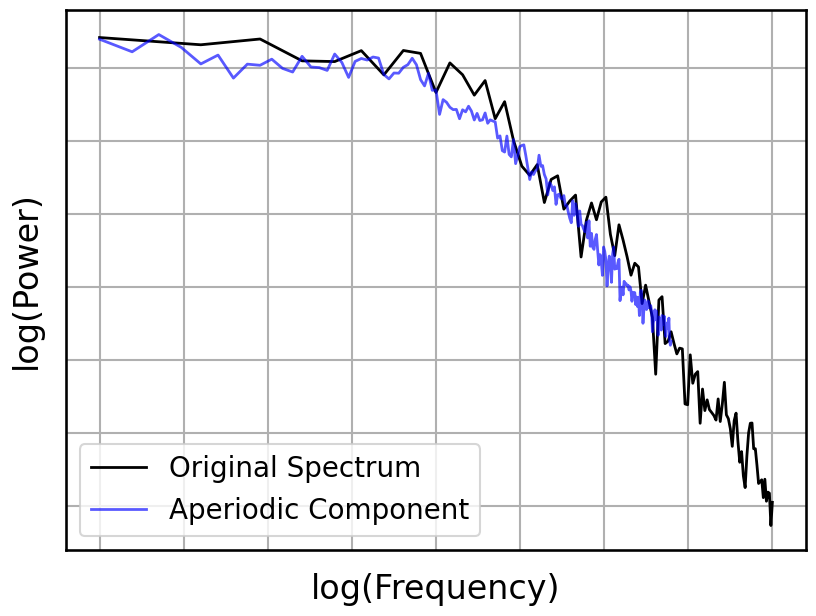

In [23]:
# Compare the full spectrum the IRASA separate aperiodic component
plot_spectra([freqs_full, freqs], [psd_full, psd_ap], 
             custom_styler=custom_psd_style_no_ticks, **PSD_PLT_KWARGS)

In [24]:
# Check the calculated value against ground truth
print('Measured Exponent (fixed):\t {:1.4f}'.format(fit_exp))
print('Measured Exponent (knee):\t {:1.4f}'.format(fit_kn_exp))
print('Expected Exponent:\t\t {:1.4f}'.format(-2))

Measured Exponent (fixed):	 -0.8061
Measured Exponent (knee):	 -1.8772
Expected Exponent:		 -2.0000


#### Peak Bandwidth

In [25]:
# Calculate IRASA and fit exponent
freqs, psd_ap, psd_pe = compute_irasa(examples['comb_peak'], **IRASA_PARAMS)
fit_off, fit_exp  = fit_irasa(freqs, psd_ap)

In [26]:
# Compute the full power spectrum
freqs_full, psd_full = compute_spectrum(examples['comb_peak'], FS, f_range=FIT_F_RANGE)

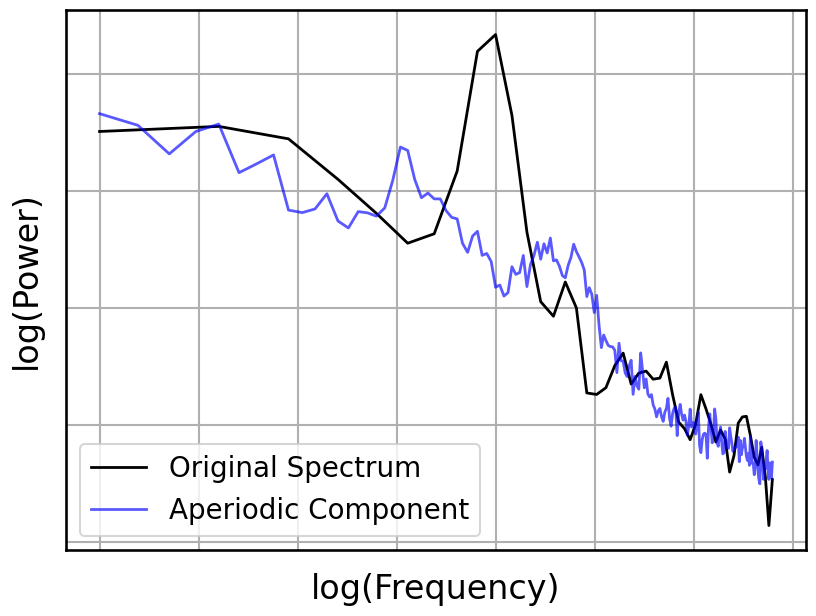

In [27]:
# Compare the full spectrum the IRASA separate aperiodic component
plot_spectra([freqs_full, freqs], [psd_full, psd_ap],
             custom_styler=custom_psd_style_no_ticks, **PSD_PLT_KWARGS)

In [28]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(SIM_ITERS.params['ap']['exponent']))

Measured Exponent:	 -1.1160
Expected Exponent:	 -1.0000


## IRASA Simulation Tests

### Simulations: Aperiodic Variations

#### Aperiodic Exponent

In [29]:
# Run a set of simulations, calculating IRASA estimation across exponents
ir_sims_exp = run_sims(sim_powerlaw, SIM_ITERS['ap_exp'], irasa, IRASA_PARAMS, N_SIMS)

#### Aperiodic Exponent (combined signal)

In [30]:
# Run a set of simulations, calculating IRASA estimation across exponents, with an oscillation
ir_sims_comb = run_sims(sim_combined, SIM_ITERS['comb_exp'], irasa, IRASA_PARAMS, N_SIMS)

#### Visualize Results

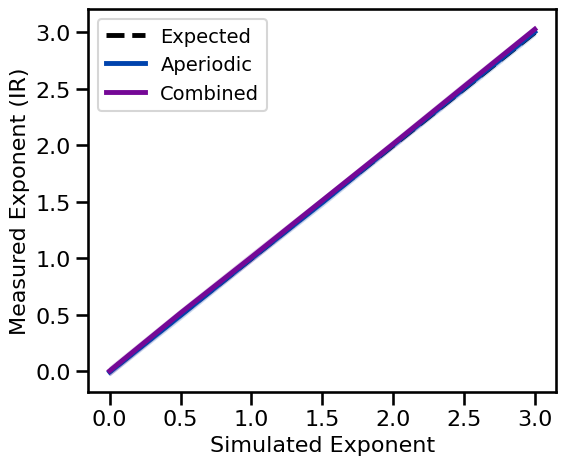

In [31]:
# Plot IRASA estimation across exponents, both with and without oscillation
plot_ap_sims(ir_sims_exp, ir_sims_comb, 'Measured Exponent (IR)',
             expected=np.abs(SIM_ITERS['ap_exp'].values), **fsaver('ir_ap'))

### Simulations: Periodic Variations

#### Oscillation Frequency

In [32]:
# Run a set of simulations, calculating IRASA across oscillation frequencies
ir_sims_freq = run_sims(sim_combined, SIM_ITERS['osc_freq'], irasa, IRASA_PARAMS, N_SIMS)

#### Oscillation Power

In [33]:
# Run a set of simulations, calculating IRASA across oscillation power
ir_sims_pow = run_sims(sim_combined, SIM_ITERS['osc_pow'], irasa, IRASA_PARAMS, N_SIMS)

#### Visualize Results

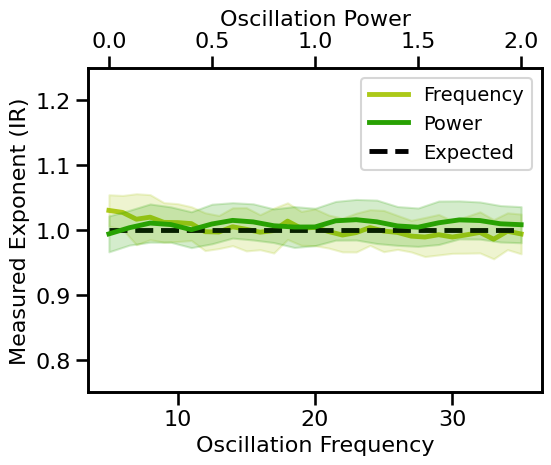

In [34]:
# Plot effect of oscillation variation on estimated exponent
plot_pe_sims(ir_sims_freq, ir_sims_pow, 'Measured Exponent (IR)',
             expected=[1.0]*len(SIM_ITERS['osc_freq']), ylim=[0.75, 1.25],
             **fsaver('ir_pe'))

## Simulations: Knee Variations

#### Without Knee Fit

In [35]:
# Run a set of simulations, calculating IRASA estimation across different timescales
ir_sims_tscales_lin = run_sims(sim_synaptic_current, SIM_ITERS['syn_tscales'],
                               irasa, IRASA_PARAMS, N_SIMS)

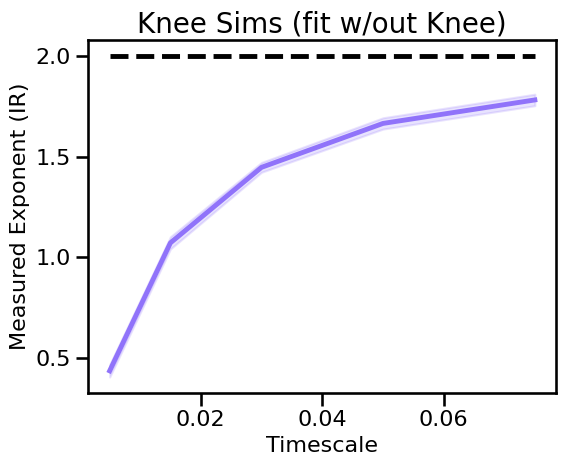

In [36]:
# Plot the estimated exponent across different timescales (estimated without a knee)
plot_sims(SIM_ITERS['syn_tscales'].values, ir_sims_tscales_lin,
          'Timescale', 'Measured Exponent (IR)', COLORS['KN'],
          expected=[2.0] * len(SIM_ITERS['syn_tscales']), title='Knee Sims (fit w/out Knee)',
          **fsaver('ir_tscales_lin'))

In [37]:
# Run simulations calculating irasa exponent across knee parameters (sims from file)
ir_sims_knee_lin = run_sims_load('ap-knee-' + str(FS), irasa, IRASA_PARAMS)

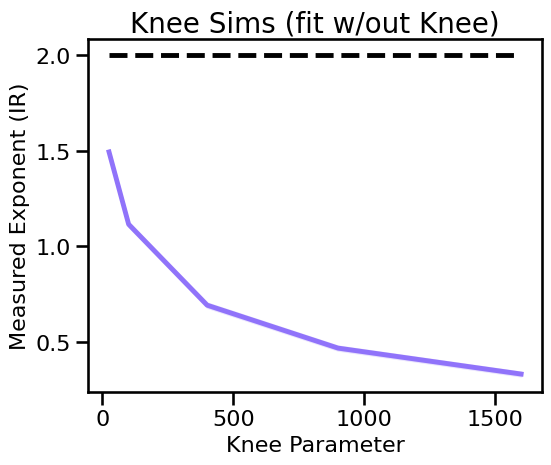

In [38]:
# Plot the estimated exponent across different timescales (estimated without a knee)
plot_sims(SIM_ITERS['kn_knee'].values, ir_sims_knee_lin, 
          'Knee Parameter', 'Measured Exponent (IR)', COLORS['KN'],
          expected=[2.0] * len(SIM_ITERS['kn_knee']), title='Knee Sims (fit w/out Knee)',
          **fsaver('ir_knee_lin'))

#### With Knee Fit

In [39]:
# Run a set of simulations, calculating IRASA estimation across different timescales
ir_sims_knee = run_sims(sim_synaptic_current, SIM_ITERS['syn_tscales'], irasa, IRASA_PARAMS_KNEE, N_SIMS)

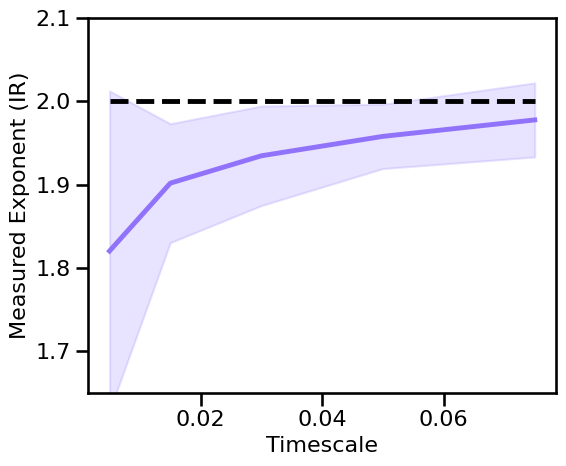

In [40]:
# Plot the estimated exponent across different timescales (estimated with a knee)
plot_sims(SIM_ITERS['syn_tscales'].values, ir_sims_knee, 'Timescale', 'Measured Exponent (IR)',
          COLORS['KN'], expected=[2.0] * len(SIM_ITERS['syn_tscales']), ylim=[1.65, 2.1],
          **fsaver('ir_tscales'))

In [41]:
# Run simulations calculating irasa exponent across knee parameters (sims from file)
ir_sims_knee = run_sims_load('ap-knee-' + str(FS), irasa, IRASA_PARAMS_KNEE)

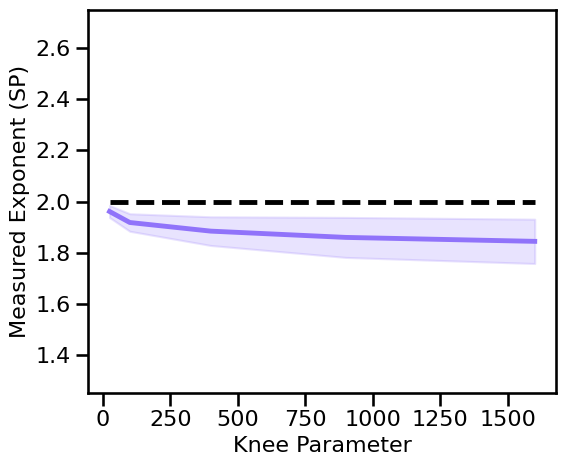

In [42]:
# Plot the estimated exponent across different timescales (estimated with a knee)
plot_sims(SIM_ITERS['kn_knee'].values, ir_sims_knee,
          'Knee Parameter', 'Measured Exponent (SP)', color=COLORS['KN'],
          expected=[2.0] * len(SIM_ITERS['kn_knee']), ylim=[1.25, 2.75],
          **fsaver('ir_knee'))

## Simulations: Periodic Variations

#### Peak Bandwidth

In [43]:
# Run a set of simulations, calculating IRASA estimate across peak bandwidth (sims from file)
ir_sims_bw = run_sims_load('comb-bw-' + str(FS), irasa, IRASA_PARAMS)

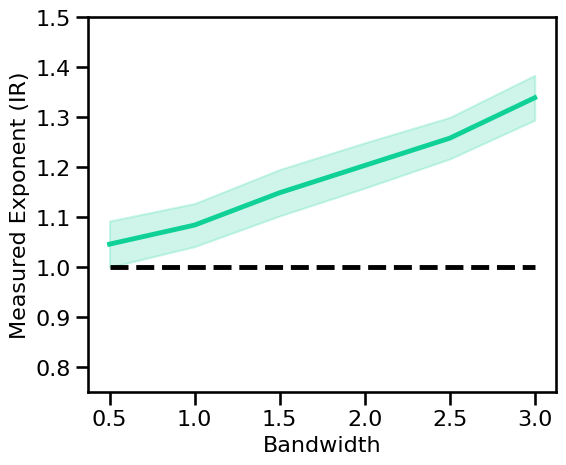

In [44]:
# Plot the estimated exponent across different peak bandwidths
plot_sims(SIM_ITERS['peak_bw'].values, ir_sims_bw, 'Bandwidth', 'Measured Exponent (IR)',
          expected=[1.0] * len(SIM_ITERS['peak_bw']), color=COLORS['BW'], ylim=[0.75, 1.5],
          **fsaver('ir_bw'))

#### Burst Probability

In [45]:
# Run simulations calculating specparam exponent across burst probabilities
ir_sims_burst = run_sims(sim_combined, SIM_ITERS['comb_burst'], irasa, IRASA_PARAMS, N_SIMS)

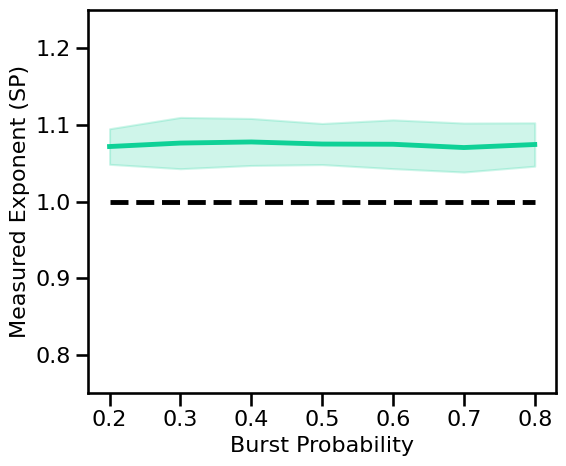

In [46]:
# Plot the estimated exponent across peak bandwidths
plot_sims(SIM_ITERS.iters['comb_burst'].values, ir_sims_burst,
          'Burst Probability', 'Measured Exponent (SP)', color=COLORS['BW'], ylim=[0.75, 1.25],
          expected=[-SIM_ITERS.params['ap']['exponent']] * len(SIM_ITERS.iters['comb_burst']),
          **fsaver('ir_burst'))

## Conclusions

Overall, we can see the following patterns in these simulations:
- IRASA is highly accurate at estimating aperiodic exponent in the case of true 1/f data
- IRASA exponent estimations are robust to variations in oscillation frequency and power (with true 1/f)
- IRASA is less robust (less accurate) at estimating the aperiodic exponent when there is an aperiodic knee
- IRASA has difficulty isolating and estimating aperiodic activity when there are are high bandwidth peaks